# DataSet link

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [1]:
# import packages
# matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

#set random seed and percentage of test data
RANDOM_SEED = 314 #used to help randomly select the data points
TEST_PCT = 0.2 # 20% of the data

#set up graphic style in this case I am using the color scheme from xkcd.com
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Normal","Fraud"]

In [2]:
col_list = ["cerulean","scarlet"]# https://xkcd.com/color/rgb/
sns.set(style='white', font_scale=1.75)
sns.set_palette(sns.xkcd_palette(col_list))

# Import and Check Data


In [4]:
df = pd.read_csv("/content/creditcard.csv")

In [5]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [6]:
df.shape

(19898, 31)

In [7]:
# No of null values in dataset
df.isnull().values.sum()

np.int64(20)

Indeed the data seems to be cleaned and loaded as we expect. Now we want to check if we have the expected number of normal and fraudulent rows of data. We will simply pull the "Class" column and count the number of normal (0) and fraud (1) rows.

In [8]:
pd.value_counts(df['Class'])

<ipython-input-8-fc0cdd7826eb>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df['Class'])


,count
Class,
0.0,19812
1.0,85


# Exploratory Data Analysis

## Balance of Data Visualization
Let's get a visual confirmation of the unbalanced data in this fraud dataset.

<ipython-input-9-a3984ab8997a>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


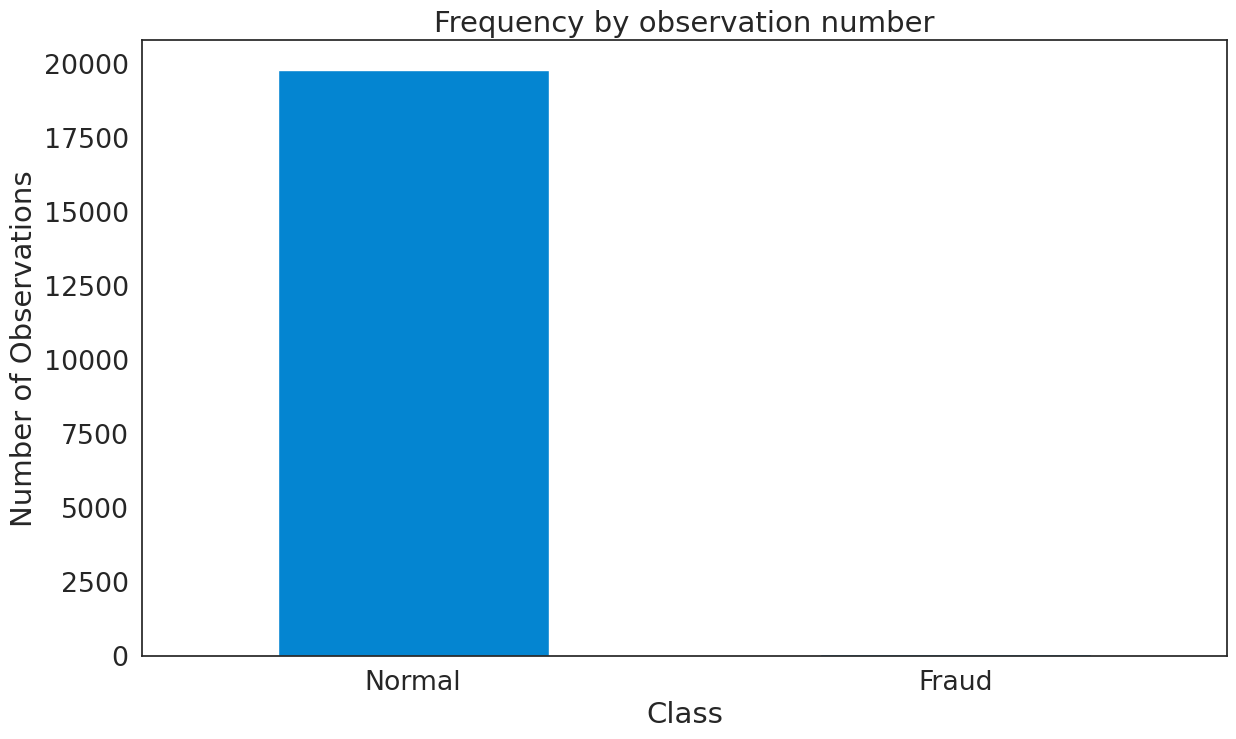

In [9]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0, figsize=(14, 8))
plt.xticks(range(2), LABELS)
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

## Summary Statistics of the Transaction Amount Data
We will cut up the dataset into two data frames, one for normal transactions and the other for fraud.

In [10]:
normal_df = df[df['Class']==0]
fraud_df = df[df['Class']==1]

In [11]:
normal_df.Amount.describe()

,Amount
count,19812.000000
mean,70.169855
std,205.091118
min,0.000000
25%,5.900000
50%,16.070000
75%,59.950000
max,7879.420000


In [12]:
fraud_df.Amount.describe()

,Amount
count,85.000000
mean,93.869647
std,261.736641
min,0.000000
25%,1.000000
50%,1.000000
75%,99.990000
max,1809.680000


Although the mean is a little higher in the fraud transactions, it is certainly within a standard deviation and so is unlikely to be easy to discriminate in a highly precise manner between the classes with pure statistical methods.

## Visual Exploration of the Transaction Amount Data

In anomaly detection datasets it is common to have the areas of interest "washed out" by abundant data. In this dataset,  a lot of low-value transactions that will be generally uninteresting (buying cups of coffee, lunches, etc). This abundant data is likely to wash out the rest of the data, so looking at transactions which are $200+

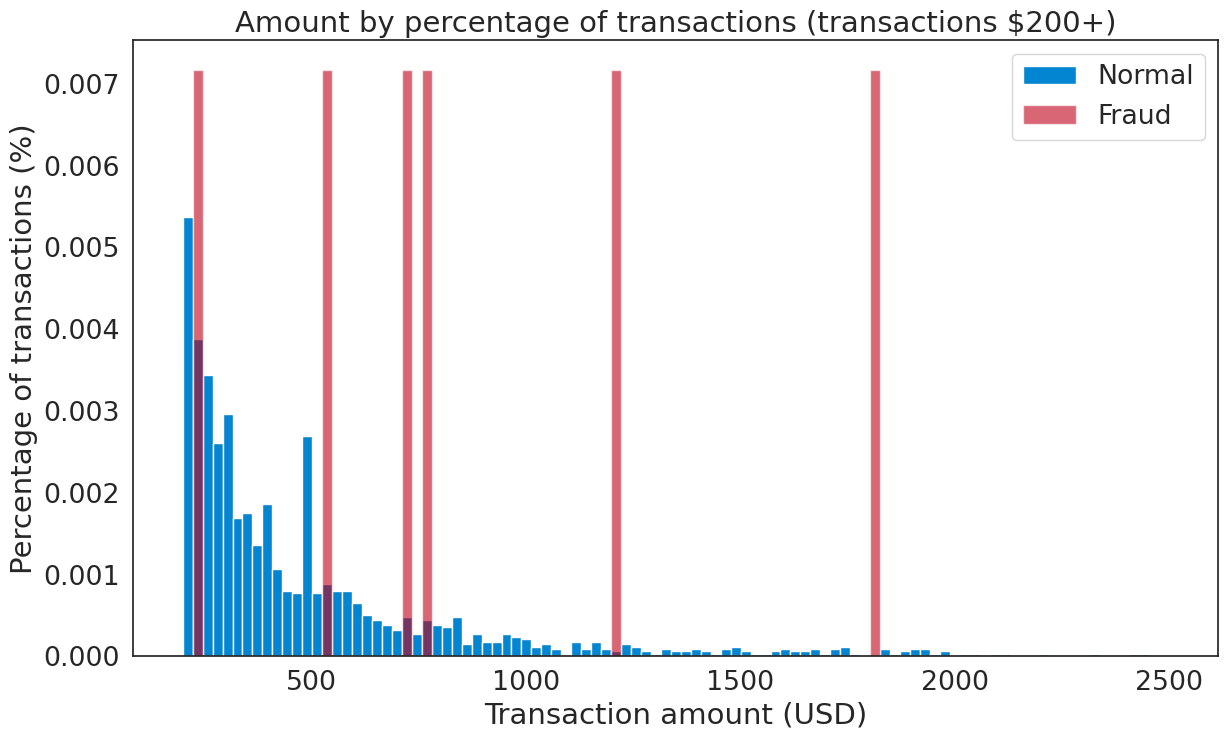

In [13]:
#plot of high value transactions
bins = np.linspace(200, 2500, 100)
plt.figure(figsize=(14, 8))
plt.hist(normal_df.Amount, bins, alpha=1, density=True, label='Normal')
plt.hist(fraud_df.Amount, bins, alpha=0.6, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions (transactions \$200+)")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)");
plt.show()

Since the fraud cases are relatively few in number compared to bin size, we see the data looks predictably more variable. In the long tail, especially, we are likely observing only a single fraud transaction. It would be hard to differentiate fraud from normal transactions by transaction amount alone.

## Visual Exploration of the Data by Hour

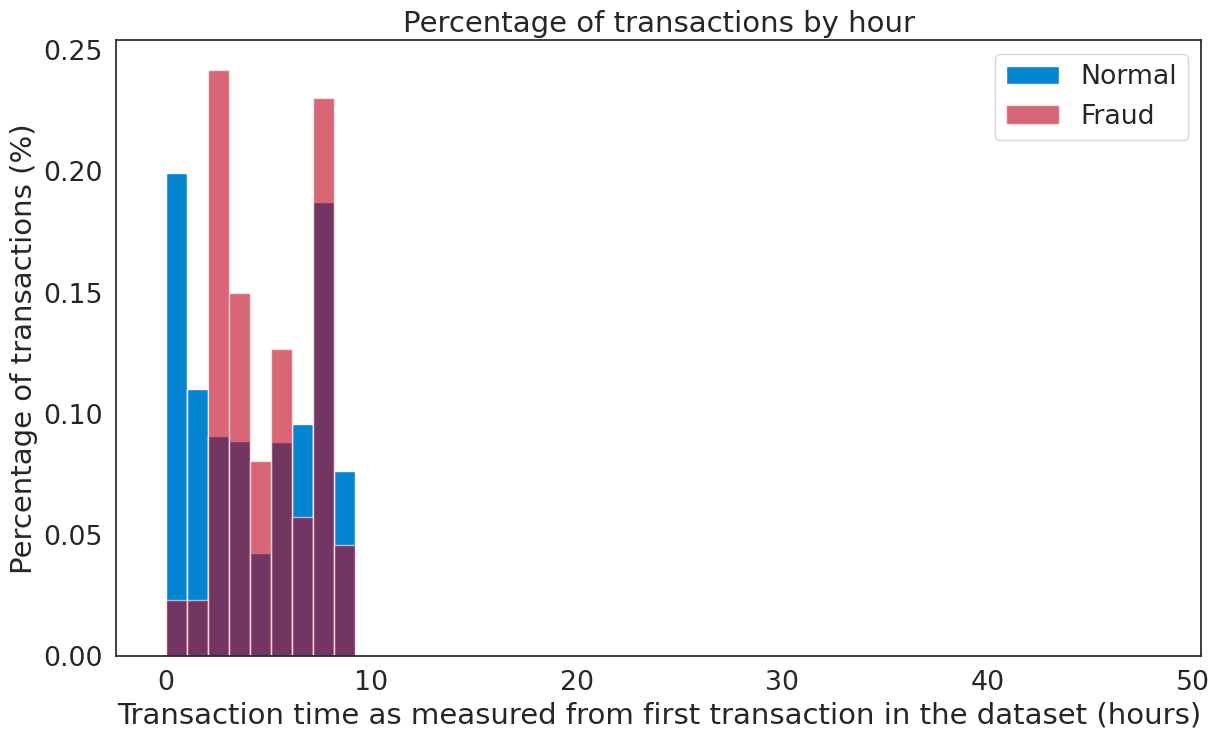

In [14]:
bins = np.linspace(0, 48, 48) #48 hours
plt.figure(figsize=(14, 8))
plt.hist((normal_df.Time/(60*60)), bins, alpha=1, density=True, label='Normal')
plt.hist((fraud_df.Time/(60*60)), bins, alpha=0.6, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Percentage of transactions by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel("Percentage of transactions (%)");
# plt.hist((df.Time/(60*60)),bins)
plt.show()

Hour "zero" corresponds to the hour the first transaction happened and not necessarily 12-1am. Given the heavy decrease in normal transactions from hours 1 to 8 and again roughly at hours 24 to 32, I am assuming those time correspond to nighttime for this dataset. If this is true, fraud tends to occur at higher rates during the night. Statistical tests could be used to give evidence for this fact, but are not in the scope of this article. Again, however, the potential time offset between normal and fraud transactions is not enough to make a simple, precise classifier.

## Visual Exploration of Transaction Amount vs. Hour

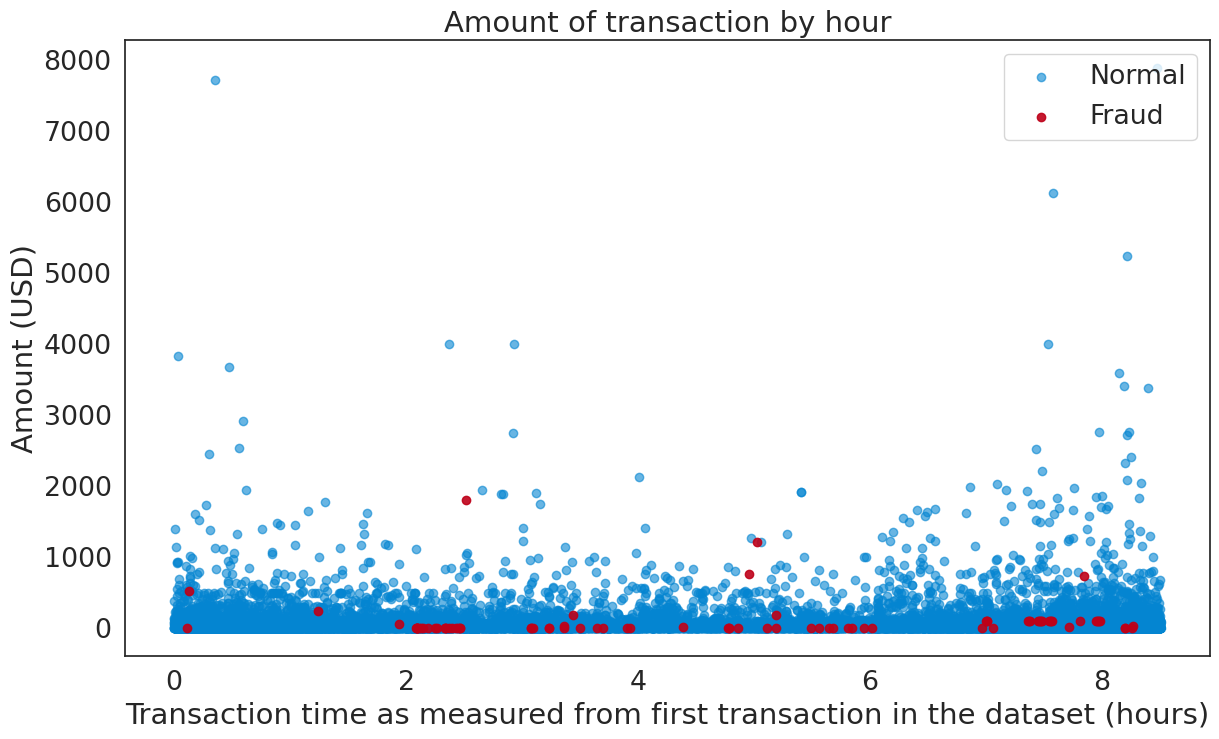

In [15]:
plt.figure(figsize=(14, 8))
plt.scatter((normal_df.Time/(60*60)), normal_df.Amount, alpha=0.6, label='Normal')
plt.scatter((fraud_df.Time/(60*60)), fraud_df.Amount, alpha=0.9, label='Fraud')
plt.title("Amount of transaction by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel('Amount (USD)')
plt.legend(loc='upper right')
plt.show()

Again, this is not enough to make a good classifier. For example, it would be hard to draw a line that cleanly separates fraud and normal transactions.

# Model Setup: Basic Autoencoder
Now that more simplistic methods are not proving that useful, we are justified in exploring our autoencoder to see if it does a little better.

## Normalize and Scale Data

Both time and amount have very different magnitudes, which will likely result in the large magnitude value "washing out" the small magnitude value. It is therefore common to scale the data to similar magnitudes. As most of the data (other than 'time' and 'amount') result from the product of a PCA analysis. The PCA done on the dataset transformed it into standard-normal form. I will do the same to the 'time' and 'amount' columns.

In [16]:
df_norm = df.copy()
# Reshape your data either using array.reshape(-1, 1) if your data has a single feature
# or array.reshape(1, -1) if it contains a single sample.
df_norm['Time'] = StandardScaler().fit_transform(df_norm['Time'].values.reshape(-1, 1))
df_norm['Amount'] = StandardScaler().fit_transform(df_norm['Amount'].values.reshape(-1, 1))

## Dividing Training and Test Set
Now we split the data into training and testing sets according to the percentage and with a random seed we wrote at the beginning of the code.

In [17]:
train_x, test_x = train_test_split(df_norm, test_size=TEST_PCT, random_state=RANDOM_SEED)
train_x = train_x[train_x.Class == 0]       # where normal transactions
train_x = train_x.drop(['Class'], axis=1)   # drop the class column


test_y = test_x['Class']                    # save the class column for the test set
test_x = test_x.drop(['Class'], axis=1)     # drop the class column

train_x = train_x.values                    # transform to ndarray
test_x = test_x.values                      # transform to ndarray

# Creating The Model

## Autoencoder Layer Structure and Parameters
Autoencoder has symmetric encoding and decoding layers that are "dense".
We are reducing the input into some form of simplified encoding and then expanding it again. The input and output dimension is the feature space (e.g. 30 columns), so the encoding layer should be smaller by an amount that expect to represent some feature. In this case, I am encoding 30 columns into 14 dimensions so I am expecting high-level features to be represented by roughly two columns (30/14 = 2.1). Of those high-level features, I am expecting them to map to roughly seven hidden/latent features in the data.

Additionally, the epochs, batch size, learning rate, learning policy, and activation functions were all set to values empirically good values.

In [18]:
nb_epoch = 50
batch_size = 128
input_dim = train_x.shape[1] #num of columns, 30
encoding_dim = 18
hidden_dim1 = 10 #int(encoding_dim / 2) #i.e. 7
hidden_dim2 = 6
learning_rate = 1e-7

In [19]:
# This returns a tensor
input_layer = Input(shape=(input_dim, ))

# a layer instance is callable on a tensor, and returns a tensor
# Dense implements the operation: output = activation(dot(input, kernel) + bias), where
# activation is the element-wise activation function passed as the activation argument,
# kernel is a weights matrix created by the layer, and
# bias is a bias vector created by the layer (only applicable if use_bias is True).

# activity_regularizer: Regularizer function applied to the output of the layer
encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim1, activation="elu")(encoder)
encoder = Dense(hidden_dim2, activation="tanh")(encoder)
decoder = Dense(hidden_dim2, activation='elu')(encoder)
decoder = Dense(hidden_dim1, activation='tanh')(decoder)
decoder = Dense(input_dim, activation='elu')(decoder)

# This creates a model that includes
# the Input layer and four Dense layers
autoencoder = Model(inputs=input_layer, outputs=decoder)

## Model Training and Logging
Below is where we set up the actual run including checkpoints and the tensorboard.

In [20]:
# Configure the learning process, by compiling the model
autoencoder.compile(optimizer='adam',
                    metrics=['accuracy'],
                    loss='mean_squared_error')

# Saving the model
cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",
                     save_best_only=True,
                     verbose=0)

# TensorBoard basic visualizations.
# This callback writes a log for TensorBoard,
# which allows you to visualize dynamic graphs of your training and test metrics
tb = TensorBoard(log_dir='./logs',
                 histogram_freq=0,
                 write_graph=True,
                 write_images=True)

# Starts training
# autoencoder: same training(x) and target data(y)
# validation_data: tuple (x_val, y_val) on which
# to evaluate the loss and any model metrics at the end of each epoch.

# History.history attribute is a record of training loss values
# and metrics values at successive epochs.
history = autoencoder.fit(x=train_x, y=train_x,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(test_x, test_x),
                          verbose=1,
                          callbacks=[cp, tb]).history

Epoch 1/50
122/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0881 - loss: 1.2138

124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.0897 - loss: 1.2119 - val_accuracy: 0.2598 - val_loss: 1.1809
Epoch 2/50
113/124 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2565 - loss: 0.9856

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2573 - loss: 0.9815 - val_accuracy: 0.3128 - val_loss: 1.0441
Epoch 3/50
114/124 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3197 - loss: 0.9004

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3211 - loss: 0.8955 - val_accuracy: 0.3709 - val_loss: 0.9849
Epoch 4/50
121/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3726 - loss: 0.7862

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3731 - loss: 0.7868 - val_accuracy: 0.4138 - val_loss: 0.9529
Epoch 5/50
117/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4184 - loss: 0.7605

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4185 - loss: 0.7618 - val_accuracy: 0.4236 - val_loss: 0.9339
Epoch 6/50
115/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4340 - loss: 0.7188

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4343 - loss: 0.7225 - val_accuracy: 0.4332 - val_loss: 0.9180
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4406 - loss: 0.7317

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4407 - loss: 0.7319 - val_accuracy: 0.4442 - val_loss: 0.9021
Epoch 8/50
116/124 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4386 - loss: 0.7545

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4394 - loss: 0.7530 - val_accuracy: 0.4462 - val_loss: 0.8878
Epoch 9/50
120/124 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4554 - loss: 0.7029

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4553 - loss: 0.7035 - val_accuracy: 0.4518 - val_loss: 0.8761
Epoch 10/50
119/124 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4524 - loss: 0.7352

124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4528 - loss: 0.7341 - val_accuracy: 0.4606 - val_loss: 0.8660
Epoch 11/50
121/124 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4727 - loss: 0.7071

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4727 - loss: 0.7071 - val_accuracy: 0.4628 - val_loss: 0.8571
Epoch 12/50
116/124 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4773 - loss: 0.7322

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4772 - loss: 0.7294 - val_accuracy: 0.4683 - val_loss: 0.8495
Epoch 13/50
112/124 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4759 - loss: 0.7008

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4766 - loss: 0.6994 - val_accuracy: 0.4789 - val_loss: 0.8421
Epoch 14/50
116/124 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4792 - loss: 0.6868

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4799 - loss: 0.6865 - val_accuracy: 0.4784 - val_loss: 0.8349
Epoch 15/50
113/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4859 - loss: 0.6937

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4863 - loss: 0.6921 - val_accuracy: 0.4849 - val_loss: 0.8285
Epoch 16/50
119/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4976 - loss: 0.6813

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4975 - loss: 0.6810 - val_accuracy: 0.4776 - val_loss: 0.8225
Epoch 17/50
121/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4975 - loss: 0.7244

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4974 - loss: 0.7226 - val_accuracy: 0.4817 - val_loss: 0.8175
Epoch 18/50
120/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4912 - loss: 0.6572

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4914 - loss: 0.6574 - val_accuracy: 0.4837 - val_loss: 0.8117
Epoch 19/50
120/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4998 - loss: 0.6805

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4995 - loss: 0.6797 - val_accuracy: 0.4869 - val_loss: 0.8076
Epoch 20/50
116/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4912 - loss: 0.6553

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4916 - loss: 0.6555 - val_accuracy: 0.4854 - val_loss: 0.8037
Epoch 21/50
118/124 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4988 - loss: 0.6227

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4990 - loss: 0.6241 - val_accuracy: 0.4894 - val_loss: 0.7994
Epoch 22/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4958 - loss: 0.6249

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4958 - loss: 0.6251 - val_accuracy: 0.4905 - val_loss: 0.7961
Epoch 23/50
123/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4959 - loss: 0.6538

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4960 - loss: 0.6537 - val_accuracy: 0.4940 - val_loss: 0.7936
Epoch 24/50
118/124 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5048 - loss: 0.6314

124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5047 - loss: 0.6320 - val_accuracy: 0.4972 - val_loss: 0.7899
Epoch 25/50
122/124 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5042 - loss: 0.6466

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5042 - loss: 0.6464 - val_accuracy: 0.4977 - val_loss: 0.7876
Epoch 26/50
117/124 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5020 - loss: 0.6747

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5023 - loss: 0.6726 - val_accuracy: 0.4972 - val_loss: 0.7848
Epoch 27/50
108/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5075 - loss: 0.6387

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5075 - loss: 0.6391 - val_accuracy: 0.4990 - val_loss: 0.7821
Epoch 28/50
115/124 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5031 - loss: 0.6321

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5036 - loss: 0.6323 - val_accuracy: 0.4952 - val_loss: 0.7796
Epoch 29/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5121 - loss: 0.6405

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5120 - loss: 0.6405 - val_accuracy: 0.5003 - val_loss: 0.7777
Epoch 30/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5137 - loss: 0.6191

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5136 - loss: 0.6192 - val_accuracy: 0.5018 - val_loss: 0.7754
Epoch 31/50
113/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5180 - loss: 0.6341

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5175 - loss: 0.6338 - val_accuracy: 0.5010 - val_loss: 0.7725
Epoch 32/50
113/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5147 - loss: 0.6410

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5147 - loss: 0.6399 - val_accuracy: 0.5083 - val_loss: 0.7707
Epoch 33/50
115/124 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5153 - loss: 0.5993

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5155 - loss: 0.6014 - val_accuracy: 0.5060 - val_loss: 0.7685
Epoch 34/50
119/124 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5166 - loss: 0.6159

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5168 - loss: 0.6162 - val_accuracy: 0.5053 - val_loss: 0.7661
Epoch 35/50
111/124 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5126 - loss: 0.6038

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5135 - loss: 0.6059 - val_accuracy: 0.5055 - val_loss: 0.7641
Epoch 36/50
110/124 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5247 - loss: 0.6098

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5246 - loss: 0.6115 - val_accuracy: 0.5065 - val_loss: 0.7620
Epoch 37/50
121/124 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5213 - loss: 0.6202

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5213 - loss: 0.6202 - val_accuracy: 0.5141 - val_loss: 0.7601
Epoch 38/50
122/124 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5235 - loss: 0.6133

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5235 - loss: 0.6133 - val_accuracy: 0.5098 - val_loss: 0.7592
Epoch 39/50
112/124 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5173 - loss: 0.6506

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5181 - loss: 0.6472 - val_accuracy: 0.5070 - val_loss: 0.7566
Epoch 40/50
115/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5144 - loss: 0.6430

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5153 - loss: 0.6410 - val_accuracy: 0.5085 - val_loss: 0.7549
Epoch 41/50
108/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5219 - loss: 0.6005

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5227 - loss: 0.6012 - val_accuracy: 0.5138 - val_loss: 0.7539
Epoch 42/50
111/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5266 - loss: 0.5994

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5267 - loss: 0.6001 - val_accuracy: 0.5193 - val_loss: 0.7521
Epoch 43/50
118/124 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5331 - loss: 0.6144

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5330 - loss: 0.6144 - val_accuracy: 0.5173 - val_loss: 0.7515
Epoch 44/50
119/124 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5262 - loss: 0.6075

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5263 - loss: 0.6074 - val_accuracy: 0.5156 - val_loss: 0.7491
Epoch 45/50
116/124 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5366 - loss: 0.6264

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5364 - loss: 0.6252 - val_accuracy: 0.5178 - val_loss: 0.7474
Epoch 46/50
120/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5338 - loss: 0.5749

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5338 - loss: 0.5761 - val_accuracy: 0.5209 - val_loss: 0.7464
Epoch 47/50
114/124 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5341 - loss: 0.6351

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5343 - loss: 0.6324 - val_accuracy: 0.5216 - val_loss: 0.7449
Epoch 48/50
119/124 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5343 - loss: 0.6323

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5342 - loss: 0.6310 - val_accuracy: 0.5307 - val_loss: 0.7427
Epoch 49/50
121/124 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5304 - loss: 0.6100

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5306 - loss: 0.6098 - val_accuracy: 0.5289 - val_loss: 0.7416
Epoch 50/50
120/124 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5355 - loss: 0.6155

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5356 - loss: 0.6149 - val_accuracy: 0.5309 - val_loss: 0.7402


In [21]:
# Visualizing metrics on local system
# !tensorboard --logdir='logs'

In [22]:
autoencoder = load_model('autoencoder_fraud.h5')

# Model Evaluation

## Model Loss
The loss of our current model seems to be converging and so more training epochs are not likely going to help. Let's explore this visually to confirm.

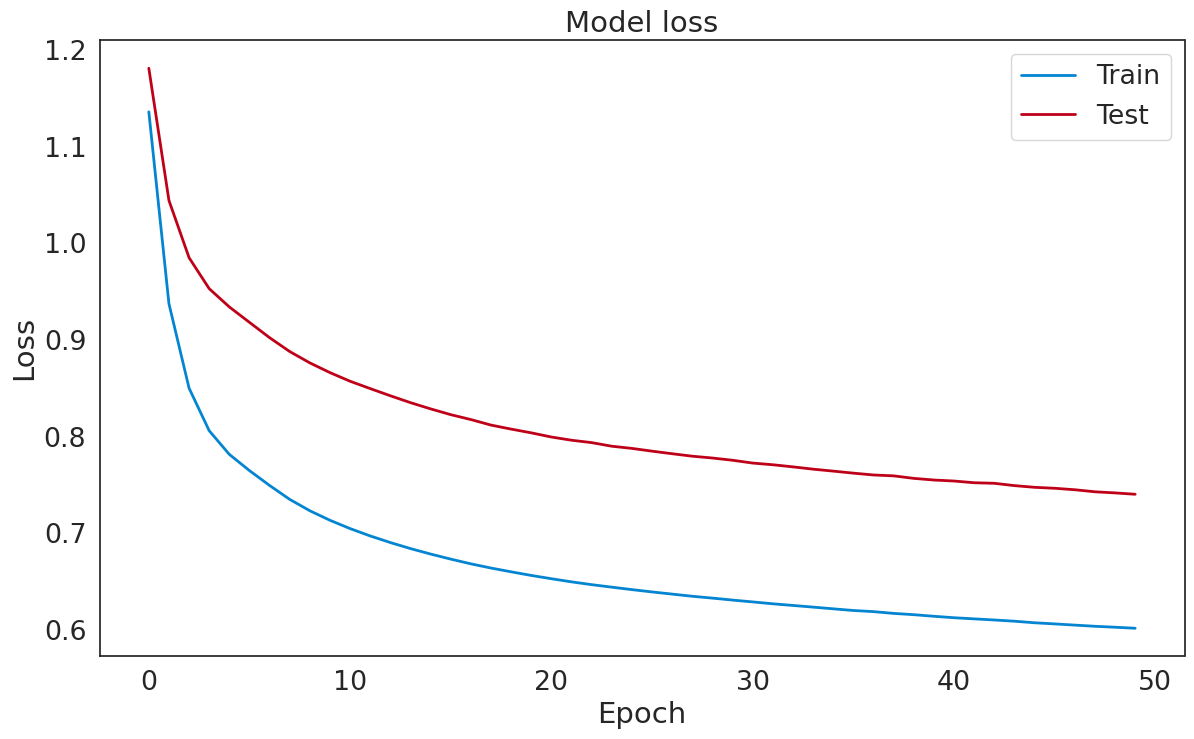

In [25]:
plt.figure(figsize=(14, 8))
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

## Reconstruction Error Check
Autoencoders are trained to reduce reconstruction error which we show below:

In [26]:
test_x_predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
error_df.describe()

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Reconstruction_error,True_class
count,3980.000000,3980.000000
mean,0.740066,0.005276
std,4.331068,0.072456
min,0.059733,0.000000
25%,0.195652,0.000000
50%,0.303326,0.000000
75%,0.460504,0.000000
max,129.603633,1.000000



## ROC Curve Check
Receiver operating characteristic curves are an expected output of most binary classifiers. Since we have an imbalanced data set they are somewhat less useful. Why? Because you can generate a pretty good-looking curve by just simply guessing everything is the normal case because there are so proportionally few cases of fraud.

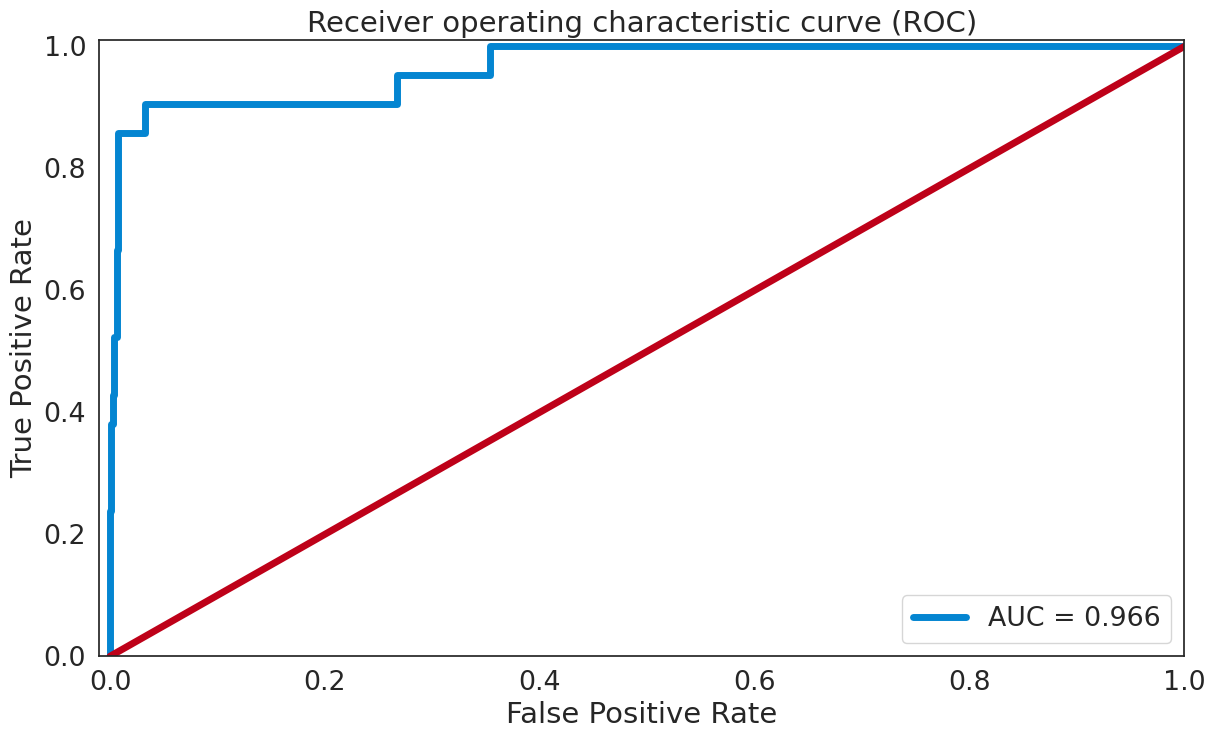

In [27]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class,
                                                      error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.figure(figsize=(14, 8))
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Recall vs. Precision Thresholding
Now let's look at recall vs. precision to see the trade-off between the two.


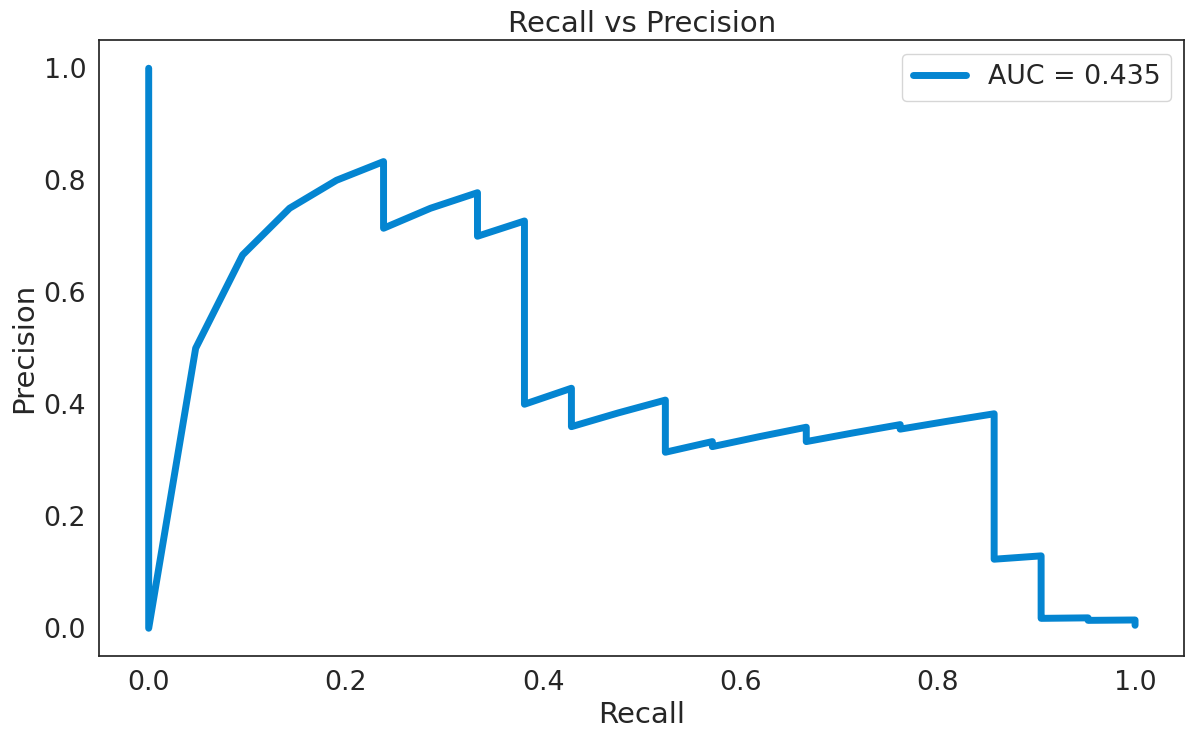

In [28]:
# calculates precision/recall using reconstruction error as the decision function
# returns:
# precision_rt: Precision values such that element i is the precision of predictions with
#               score >= thresholds[i] and the last element is 1.
# recall_rt: Decreasing recall values such that element i is the recall of predictions with
#           score >= thresholds[i] and the last element is 0.
# threshold_rt = Increasing thresholds on the decision function used to compute
#                precision and recall.
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class,
                                                               error_df.Reconstruction_error)

pr_auc = auc(recall_rt, precision_rt,)

plt.figure(figsize=(14, 8))
plt.plot(recall_rt, precision_rt, linewidth=5, label='AUC = %0.3f'% pr_auc)
plt.legend(loc='upper right')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

Precision and recall are the eternal tradeoff in data science, so at some point you have to draw an arbitrary line, or a threshold. Where this line will be drawn is essentially a business decision. In this case, you are trading off the cost between missing a fraudulent transaction and the cost of falsely flagging the transaction as a fraudulent even when it is not.

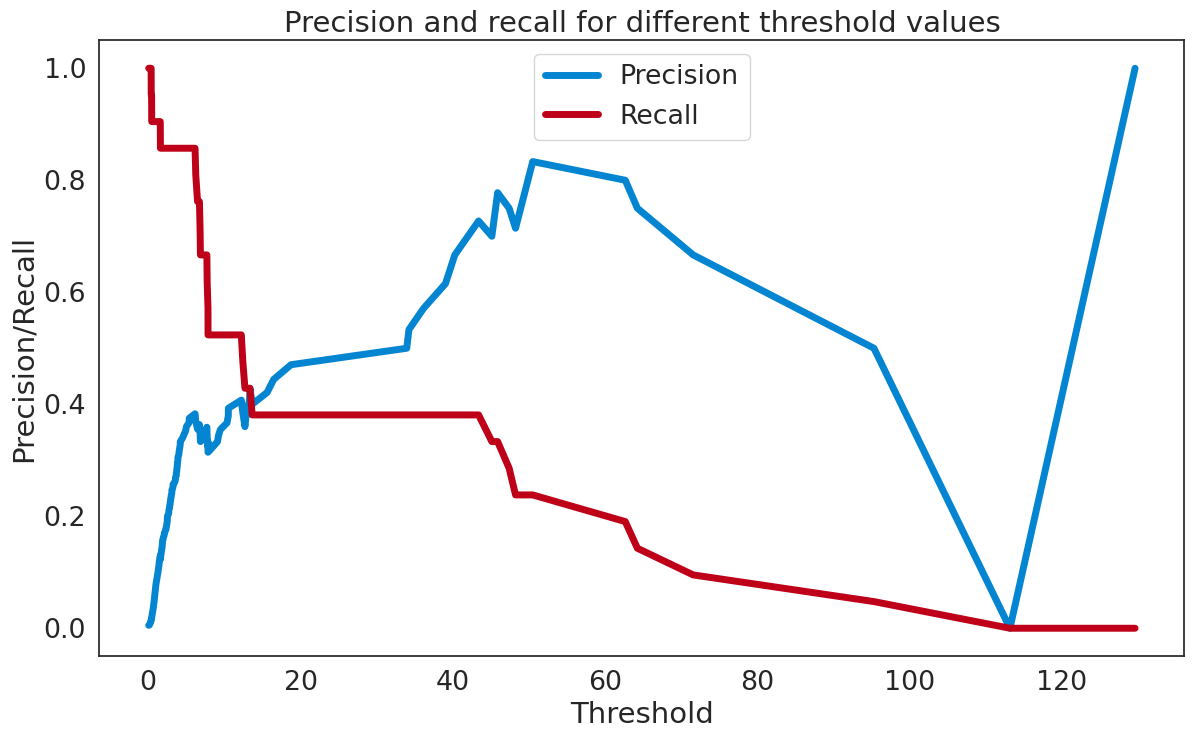

In [29]:
plt.figure(figsize=(14, 8))
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

## Reconstruction Error vs Threshold Check

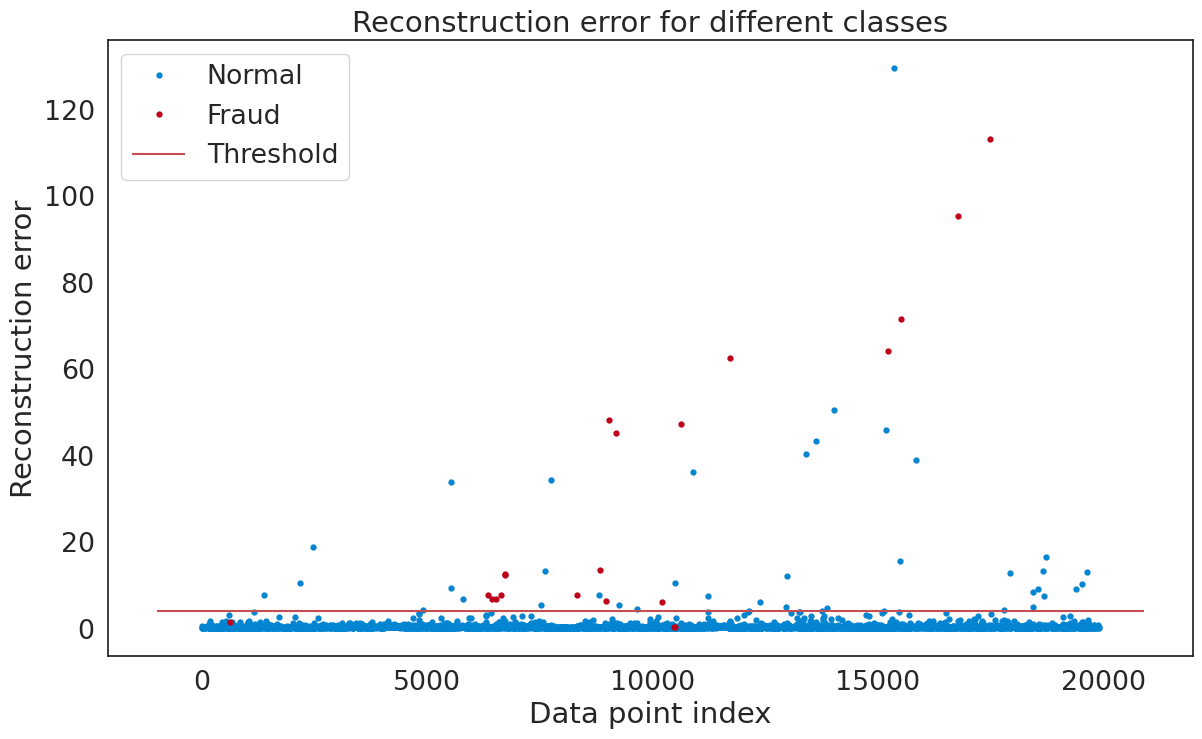

In [30]:
threshold_fixed = 4
groups = error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(14, 8))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1],
          colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

## Confusion Matrix
Finally, we take a look at a traditional confusion matrix for the 20% of the data we randomly held back in the testing set. Here I really take a look at the ratio of detected fraud cases to false positives. A 1:10 ratio is a fairly standard benchmark if there are no business rules or cost tradeoffs that dominate that decision.

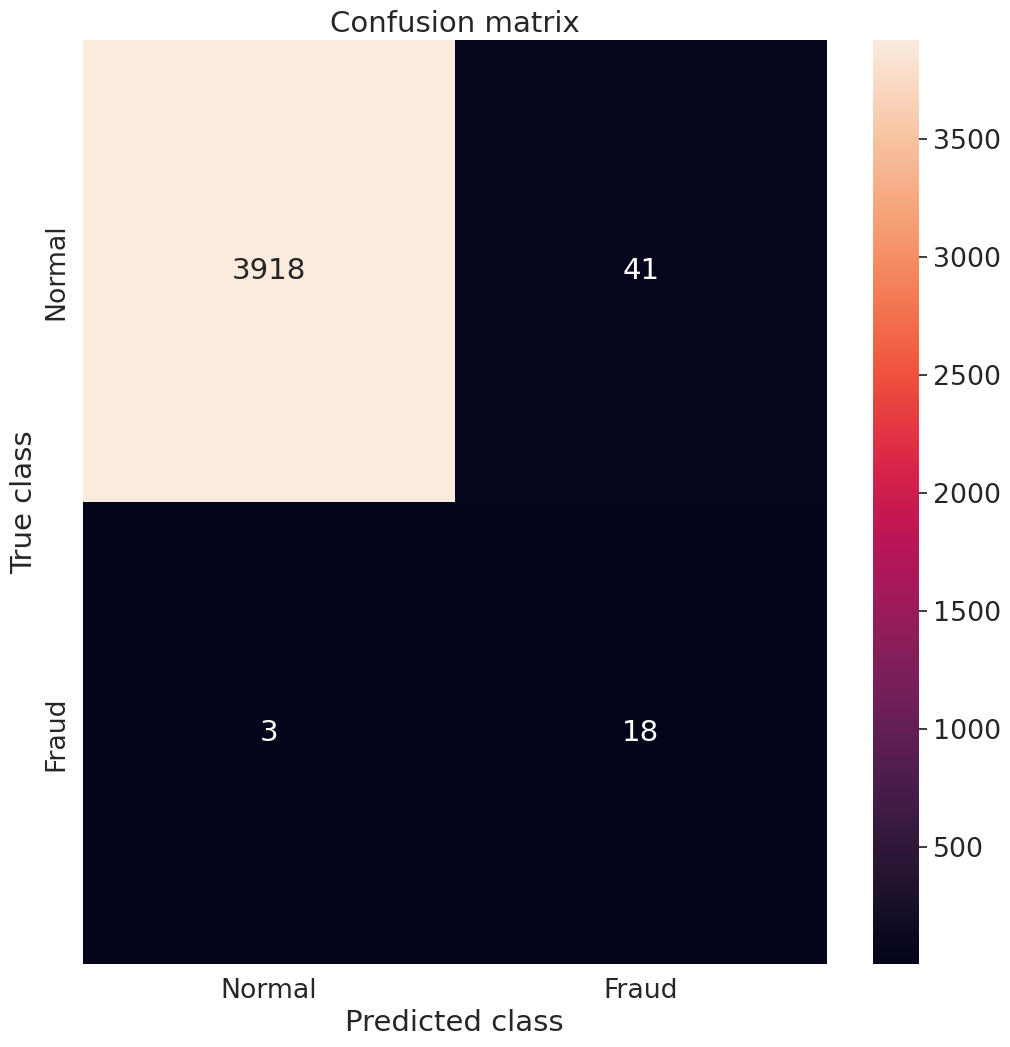

In [31]:
# As with autoencoders, it is the assumption that fraud or anomalies will suffer
# from a detectably high reconstruction error, predicting class as 1 (Fraud)
# if reconstruction error is greater than threshold
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()